# Classification of Product Category

In [44]:
## Load Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Import Dataset

In [45]:
retail_sales = pd.read_csv('../data/processed/retail_sales_dataset_cleaned.csv')
retail_sales.head(20)

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,year,month,month_name,weekday
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,2023,11,Nov,Friday
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,2023,2,Feb,Monday
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,2023,1,Jan,Friday
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,2023,5,May,Sunday
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,2023,5,May,Saturday
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30,2023,4,Apr,Tuesday
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50,2023,3,Mar,Monday
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100,2023,2,Feb,Wednesday
8,9,2023-12-13,CUST009,Male,63,Electronics,2,300,600,2023,12,Dec,Wednesday
9,10,2023-10-07,CUST010,Female,52,Clothing,4,50,200,2023,10,Oct,Saturday


## Preprocessing 

In [46]:
# Create copy of data
retail_sales_copy = retail_sales.copy()

# Define x and y variables
X = retail_sales_copy[['gender', 'age', 'quantity', 'price_per_unit', 'total_amount', 'year', 'month', 'weekday']]
y = retail_sales_copy['product_category']

# Define numeric and categorical columns
num_cols = ['age', 'quantity', 'price_per_unit', 'total_amount', 'year', 'month']
cat_cols = ['gender', 'weekday']

# Define preprocessing pipeline
preproc = ColumnTransformer([
    ('numeric', StandardScaler(), num_cols),
    ('categorical', OneHotEncoder(drop='first'), cat_cols)
], remainder='passthrough')
preproc


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric', ...), ('categorical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``fea

## Evaluate Models  

In [47]:
# Logistic regression pipeline
pipe_a = Pipeline([
    ('preprocessing', preproc),
    ('model', LogisticRegression())
])

# Random forest pipeline
pipe_b = Pipeline([
    ('preprocessing', preproc),
    ('model', RandomForestClassifier())
])

# Train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 6)

# Define scoring metrics
scoring = {
    'f1': 'f1_macro',
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

# Cross-valdiation
pipe_a_scores = cross_validate(pipe_a, X_train,y_train, cv=5, scoring = scoring)
pipe_a_scores_df = pd.DataFrame(pipe_a_scores)

pipe_b_scores = cross_validate(pipe_b, X_train,y_train, cv=5, scoring = scoring)
pipe_b_scores_df = pd.DataFrame(pipe_b_scores)

# Create dataframe of scroring metrics for both models
metrics = ['test_f1', 'test_accuracy', 'test_precision', 'test_recall']

pipe_a_mean = pipe_a_scores_df[metrics].mean()
pipe_b_mean = pipe_b_scores_df[metrics].mean()

scoring_df = pd.DataFrame({
    'Logistic Regression': pipe_a_mean,
    'Random Forest': pipe_b_mean
})
scoring_df


,Logistic Regression,Random Forest
test_f1,0.329279,0.319163
test_accuracy,0.355000,0.326250
test_precision,0.346136,0.320318
test_recall,0.343995,0.321016


**Best Model:**
Logistic regression slightly outperforms random forest on all scoring metrics. 

## Fit Logistic Regression Model and Evaluate Performance

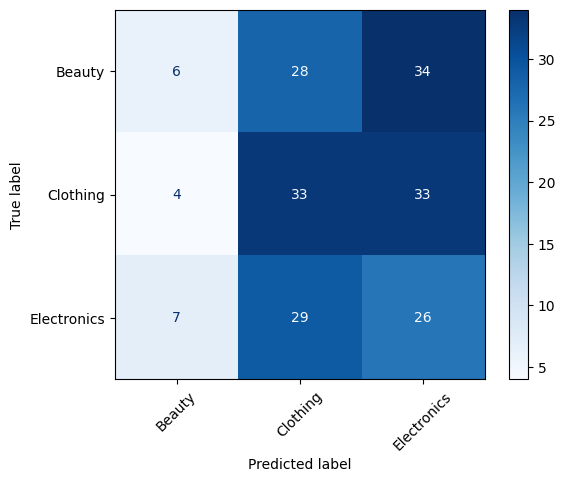

In [48]:
# Fit model
pipe_a.fit(X_train, y_train)

# Make predictions on test dataset
y_pred = pipe_a.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipe_a.classes_)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_a.classes_)
cm_display.plot(cmap='Blues', xticks_rotation=45)